In [1]:
## Custom Modules
#=======================================================================================================================
import sys
import os 
import tqdm
import h5py
import dill
import subprocess
import time
import pickle
from _custom_functions import KM, CIF, metric_table, round_
from _plots import Age_Sex_plot, risk_plot_5yr, cumhaz_plot 

import numpy as np 
import pandas as pd 
from sklearn import metrics
from scipy import interp
from sklearn.linear_model import LinearRegression
from scipy.stats.mstats import gmean

from statsmodels.stats.multitest import multipletests
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

ROOT_DIR = '/nfs/research/sds/sds-ukb-cancer/'

sys.path.append(ROOT_DIR + 'projects/CancerRisk/scripts/model')
from m1 import predictor

events = ['oesophagus', 'stomach', 'colorectal', 'liver', 'pancreas', 'lung', 'melanoma', 'breast', 
                'cervix_uteri', 'corpus_uteri', 'ovary', 'prostate', 'testis', 'kidney', 'bladder', 'brain',
                'thyroid', 'non_hodgkin_lymphoma', 'multiple_myeloma', 'AML', 'other', 'death']


Events = ['Oesophagus', 'Stomach', 'Colorectal', 'Liver', 'Pancreas', 'Lung', 'Melanoma', 'Breast', 
                'Cervix Uteri', 'Corpus Uteri', 'Ovary', 'Prostate', 'Testis', 'Kidney', 'Bladder', 'Brain',
                'Thyroid', 'NHL', 'MM', 'AML', 'Other', 'Death']

for cc in range(22):
    print(cc, events[cc])

disease_codes = np.load(ROOT_DIR + 'projects/CancerRisk/data/prep/disease_codes.npy', allow_pickle=True)

0 oesophagus
1 stomach
2 colorectal
3 liver
4 pancreas
5 lung
6 melanoma
7 breast
8 cervix_uteri
9 corpus_uteri
10 ovary
11 prostate
12 testis
13 kidney
14 bladder
15 brain
16 thyroid
17 non_hodgkin_lymphoma
18 multiple_myeloma
19 AML
20 other
21 death


In [2]:
## Model
#=======================================================================================================================
tt = [pickle.load(open(ROOT_DIR + 'projects/CancerRisk/model/' + events[cc] + '/param.pkl', 'rb')) for cc in range(22)]
A0 = np.load(ROOT_DIR + 'projects/CancerRisk/model/' + 'all' + '/breslow.npy')
A0_base = np.load(ROOT_DIR + 'projects/CancerRisk/model/' + 'all' + '/ukb_agesex.npy')     

In [3]:
## Plotting Setup
#=======================================================================================================================

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.grid'] = False

mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['axes.titlepad'] = 1
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['hatch.linewidth'] = 0.5

plt.rcParams['font.size'] = 6
fontsize=6

cm = 1/2.54

colormap= np.asarray(['#1E90FF', '#BFEFFF', '#191970', '#87CEFA', '#008B8B', '#946448', '#421a01', '#6e0b3c', 
                '#9370DB', '#7A378B', '#CD6090', '#006400', '#5ebd70', '#f8d64f', '#EEAD0E', '#f8d6cf',
                '#CDCB50', '#CD6600', '#FF8C69', '#8f0000', '#b3b3b3', '#454545'])
cmap = mpl.cm.get_cmap('RdBu')

In [7]:
## Extract Data
#======================================================================================================================
time = []
pred = []
for run_id in tqdm.tqdm(range(101)):
    with h5py.File(ROOT_DIR + 'projects/CancerRisk/data/main/predictions/ukb_' + str(run_id) + '.h5', 'r') as f:
        ll = list(f.keys())
        for ii in ll:
            time.extend(f[ii]['time'][:, :].tolist())
            pred.extend(f[ii]['pred'][:, :].tolist())
time = np.asarray(time).astype(float)
pred = np.asarray(pred).astype(float)

qrisk = []
pred2 = []
for run_id in tqdm.tqdm(range(101)):
    with h5py.File(ROOT_DIR + 'projects/CancerRisk/data/main/predictions/ukb2_' + str(run_id) + '.h5', 'r') as f:
        ll = list(f.keys())
        for ii in ll:
            pred2.extend([f[ii]['pred_sub'][:, :].tolist()])
    with h5py.File(ROOT_DIR + 'projects/CancerRisk/data/main/predictions/qrisk_' + str(run_id) + '.h5', 'r') as f:
        #ll = list(f.keys())
        for ii in ll:
            qrisk.extend([f[ii]['pred'][:, :].tolist()]) 

pred2 = np.asarray(pred2).astype(float)
qrisk = np.asarray(qrisk).astype(float)





'''
dcodes = []
for run_id in tqdm.tqdm(range(101)):
    with h5py.File(ROOT_DIR + 'projects/CancerRisk/data/main/disease_freq/ukb_' + str(run_id) + '.h5', 'r') as f:
        ll = list(f.keys())
        for ii in ll:
            dcodes.extend(f[ii]['X'][:, :].tolist())
dcodes = np.asarray(dcodes).astype(float)
dcodes = np.minimum(dcodes, 1) 
'''

'''
Apred = []
for run_id in tqdm.tqdm(range(252)):
    with h5py.File(ROOT_DIR + 'projects/CancerRisk/data/main/predictions_dynamic/ukb_' + str(run_id) + '.h5', 'r') as f:
        ll = list(f.keys())
        for ii in ll:
            Apred.extend(f[ii]['absolute_risk'][:, :, :].tolist())
'''

tt_surv = time[:, 0]
sex = time[:, 1].astype(bool)
age = time[:, 2].astype(int)
out = pred[:, 0, :].copy()
predage = np.arange(18250, 25581, 31)

# collect all predictions - 5yrs
prediction=[]
for cc in (range(22)):
    print(events[cc])
    idx = np.logical_or(sex, ~sex)
    ee = pred[idx, 0, cc].copy()
    y_ = ee
    tt_ = time[:, 0][idx].copy()
    cif_ = CIF(cc=cc, tt0=age[idx], tt_range=1825, A0=A0, pred=pred[idx, 1, :], sex=sex.astype(int)[idx])
    pp=[]
    for ii in tqdm.tqdm(range(np.sum(idx))):
        pp.extend(cif_(ii))
    pp = np.asarray(pp)
    prediction.extend([pp[:, None]])    
prediction = np.concatenate((prediction), axis=1)
# adjust sex specific cancers
prediction[~sex, 11:13] = 0
prediction[sex, 7:11] = 0    


100%|██████████| 101/101 [06:18<00:00,  3.75s/it]


oesophagus


100%|██████████| 377004/377004 [00:58<00:00, 6457.45it/s]


stomach


100%|██████████| 377004/377004 [00:58<00:00, 6458.71it/s]


colorectal


100%|██████████| 377004/377004 [00:58<00:00, 6461.58it/s]


liver


100%|██████████| 377004/377004 [00:58<00:00, 6448.70it/s]


pancreas


100%|██████████| 377004/377004 [00:58<00:00, 6443.35it/s]


lung


100%|██████████| 377004/377004 [00:58<00:00, 6426.54it/s]


melanoma


100%|██████████| 377004/377004 [00:58<00:00, 6435.88it/s]


breast


100%|██████████| 377004/377004 [00:58<00:00, 6432.88it/s]


cervix_uteri


100%|██████████| 377004/377004 [00:58<00:00, 6440.11it/s]


corpus_uteri


100%|██████████| 377004/377004 [00:58<00:00, 6426.23it/s]


ovary


100%|██████████| 377004/377004 [00:58<00:00, 6417.38it/s]


prostate


100%|██████████| 377004/377004 [00:58<00:00, 6418.25it/s]


testis


100%|██████████| 377004/377004 [00:58<00:00, 6411.65it/s]


kidney


100%|██████████| 377004/377004 [00:58<00:00, 6402.71it/s]


bladder


100%|██████████| 377004/377004 [00:58<00:00, 6412.98it/s]


brain


100%|██████████| 377004/377004 [00:58<00:00, 6402.68it/s]


thyroid


100%|██████████| 377004/377004 [00:58<00:00, 6400.45it/s]


non_hodgkin_lymphoma


100%|██████████| 377004/377004 [00:59<00:00, 6372.33it/s]


multiple_myeloma


100%|██████████| 377004/377004 [00:58<00:00, 6414.49it/s]


AML


100%|██████████| 377004/377004 [00:58<00:00, 6408.03it/s]


other


100%|██████████| 377004/377004 [00:58<00:00, 6394.43it/s]


death


100%|██████████| 377004/377004 [00:58<00:00, 6393.45it/s]


In [8]:
qrisk.shape

(377004, 1, 22)

In [48]:
eid

NameError: name 'eid' is not defined

In [51]:
eid=[]
for run_id in tqdm.tqdm(range(101)):
    with h5py.File(ROOT_DIR + 'projects/CancerRisk/data/main/predictions/ukb_' + str(run_id) + '.h5', 'r') as f:
        ll = list(f.keys())
        eid.extend(ll)
eid = np.asarray(eid)

100%|██████████| 101/101 [00:14<00:00,  6.93it/s]


In [4]:
eth = pd.read_csv(ROOT_DIR + 'projects/CancerRisk/tmp/eth.csv')

In [5]:
idx = []
for ii in np.asarray(eth.iloc[:, 1]):
    idx.extend([np.any(str(ii)==eid)])
idx = np.asarray(idx)

NameError: name 'eid' is not defined

In [ ]:
idx.sum()

In [6]:
eth = eth.loc[idx, :]

In [7]:
eth = np.asarray(eth.iloc[:, -1])

In [75]:
np.unique(eth.astype('S1').astype(str), return_counts=True)

(array(['-', '1', '2', '3', '4', '5', '6', 'n'], dtype='<U1'),
 array([  1421, 354740,   2151,   7460,   5919,   1251,   3412,    650]))

In [90]:
1421+650+3412+354740+2151+7460+5919+1251

377004

In [95]:
1251/idx.sum()*100

0.33182671801890695

In [89]:
94.1+0.57+1.98+1.57+0.33+1.4

99.94999999999999

In [26]:
colormap
for cc in np.where(np.sum(qrisk, axis=0)!= 0)[1]:

array(['#1E90FF', '#BFEFFF', '#191970', '#87CEFA', '#008B8B', '#946448',
       '#421a01', '#6e0b3c', '#9370DB', '#7A378B', '#CD6090', '#006400',
       '#5ebd70', '#f8d64f', '#EEAD0E', '#f8d6cf', '#CDCB50', '#CD6600',
       '#FF8C69', '#8f0000', '#b3b3b3', '#454545'], dtype='<U7')

In [ ]:
colormap

In [21]:
## Metrics
#=======================================================================================================================
concordance_qrisk=[]
concordance_cox=[]

for cc in np.where(np.sum(qrisk, axis=0)!= 0)[1]:
    print(events[cc])
    
    if cc in [7, 8, 9, 10]:
        idx = ~sex
    elif cc in [11, 12]:
        idx = sex
    else:
        idx = np.logical_or(sex, ~sex)
        
    ee = pred[idx, 0, cc].copy()
    y_ = ee
    tt_ = tt_surv[idx].copy()
    
    cif_ = CIF(cc=cc, tt0=age[idx], tt_range=1195, A0=A0, pred=pred[idx, 1, :], sex=sex.astype(int)[idx])
    pp=[]
    for ii in tqdm.tqdm(range(np.sum(idx))):
        pp.extend(cif_(ii))
    pp = np.asarray(pp)
    
    dd = pd.DataFrame(np.concatenate((tt_surv[idx, None], y_[:, None], pp[:, None], qrisk[idx, 0, cc, None]), axis=1).astype(float))
    dd.columns = ['time', 'events', 'cox', 'qrisk']
    dd.to_csv(ROOT_DIR + 'projects/CancerRisk/output/' + events[cc] + '/data/comparision_raw.csv', sep=';')

    a = '''
    rm(list=ls())
    library(survival)
    ROOT_DIR = '/nfs/research/sds/sds-ukb-cancer/projects/CancerRisk/'
    '''

    b = 'data_name = ' + "'output/" + str(events[cc]) + "/data/comparision_raw.csv'"

    c = '''
    dd <- read.csv(paste(ROOT_DIR, data_name, sep=''), header=TRUE, sep=';')

    m = coxph(Surv(time, events)~cox, data=dd)
    x = paste(unname(summary(m)$concordance[1]), unname(summary(m)$concordance[2]), sep=';')
    write(x, file=paste('/nfs/research/sds/sds-ukb-cancer/projects/CancerRisk/tmp3/est_conc1.txt', sep=''), append=FALSE, sep=";")
    
        m = coxph(Surv(time, events)~qrisk, data=dd)
    x = paste(unname(summary(m)$concordance[1]), unname(summary(m)$concordance[2]), sep=';')
    write(x, file=paste('/nfs/research/sds/sds-ukb-cancer/projects/CancerRisk/tmp3/est_conc2.txt', sep=''), append=FALSE, sep=";")
    
    '''

    with open('/nfs/research/sds/sds-ukb-cancer/projects/CancerRisk/tmp3/est_conc.R', 'w') as write_out:
        write_out.write(a+b+c)

    subprocess.check_call(['Rscript', '/nfs/research/sds/sds-ukb-cancer/projects/CancerRisk/tmp3/est_conc.R'], shell=False)
    os.remove('/nfs/research/sds/sds-ukb-cancer/projects/CancerRisk/tmp3/est_conc.R')

    conc = np.squeeze(np.loadtxt('/nfs/research/sds/sds-ukb-cancer/projects/CancerRisk/tmp3/est_conc1.txt', delimiter=';'))
    concordance_cox.extend([conc.tolist()])
    
    conc = np.squeeze(np.loadtxt('/nfs/research/sds/sds-ukb-cancer/projects/CancerRisk/tmp3/est_conc2.txt', delimiter=';'))
    concordance_qrisk.extend([conc.tolist()])


    os.remove('/nfs/research/sds/sds-ukb-cancer/projects/CancerRisk/tmp3/est_conc1.txt')
    os.remove('/nfs/research/sds/sds-ukb-cancer/projects/CancerRisk/tmp3/est_conc2.txt')
    

oesophagus


100%|██████████| 377004/377004 [00:42<00:00, 8840.40it/s]


stomach


100%|██████████| 377004/377004 [00:42<00:00, 8927.75it/s]


colorectal


100%|██████████| 377004/377004 [00:43<00:00, 8711.33it/s]


pancreas


100%|██████████| 377004/377004 [00:43<00:00, 8727.19it/s]


lung


100%|██████████| 377004/377004 [00:42<00:00, 8877.75it/s]


breast


100%|██████████| 207233/207233 [00:23<00:00, 8962.47it/s]


cervix_uteri


100%|██████████| 207233/207233 [00:23<00:00, 8932.88it/s]


corpus_uteri


100%|██████████| 207233/207233 [00:23<00:00, 8950.29it/s]


ovary


100%|██████████| 207233/207233 [00:23<00:00, 8929.01it/s]


prostate


100%|██████████| 169771/169771 [00:19<00:00, 8912.67it/s]


testis


100%|██████████| 169771/169771 [00:19<00:00, 8930.20it/s]


kidney


100%|██████████| 377004/377004 [00:42<00:00, 8911.16it/s]


AML


100%|██████████| 377004/377004 [00:42<00:00, 8902.74it/s]


In [22]:
concordance_cox = np.asarray(concordance_cox)
concordance_qrisk = np.asarray(concordance_qrisk)

In [44]:
qrisk_conc = pd.DataFrame(concordance_qrisk)
qrisk_conc.columns = ['qrisk_concordance', 'qrisk_sd']
qrisk_conc.to_csv(ROOT_DIR + 'projects/CancerRisk/output/' + 'main' + '/tables/qrisk.csv')

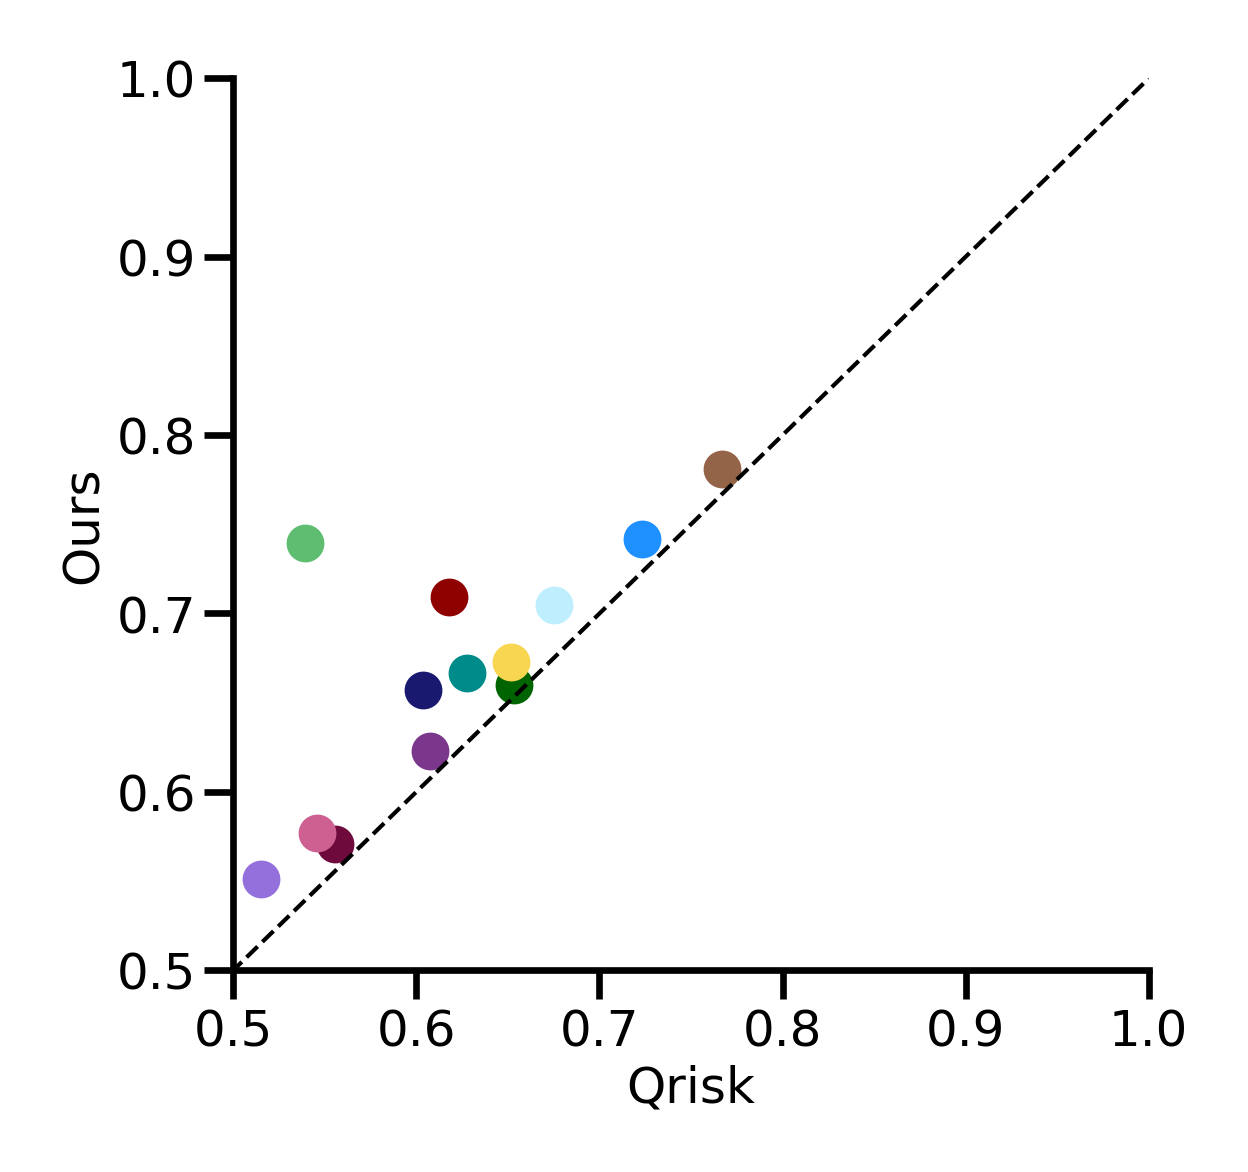

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5*cm, 5*cm), dpi=600, sharey=True)
fig.subplots_adjust(wspace=0.05)

ax.plot([0, 1], [0, 1], color='black', ls='--', lw=0.5) 

n = 0
for cc in np.where(np.sum(qrisk, axis=0)!= 0)[1]:
    col = colormap[cc]             
    ax.scatter(x=concordance_qrisk[n, 0], y=concordance_cox[n, 0], marker='.', color=col, s=50)
    n += 1
ax.set_xlim([0.5, 1])
ax.set_ylim([0.5, 1])
ax.set_xlabel('Qrisk')
ax.set_ylabel('Ours')

plt.savefig(ROOT_DIR + 'projects/CancerRisk/output/' + 'main' + '/figures/qrisk.pdf', dpi=600, bbox_inches='tight', transparent=True)
plt.show()
plt.close()   

In [32]:
concordance_cox

array([[0.7419903 , 0.01364592],
       [0.70475394, 0.01724511],
       [0.65692131, 0.00709695],
       [0.66681346, 0.01369133],
       [0.78111722, 0.00701388],
       [0.57091168, 0.00613095],
       [0.55132001, 0.05419731],
       [0.62291667, 0.01468783],
       [0.57705005, 0.01705078],
       [0.6599203 , 0.00502697],
       [0.73964312, 0.09582207],
       [0.6728318 , 0.013885  ],
       [0.70916887, 0.03793483]])

In [ ]:
plt.scatter(concordance_qrisk, concordance_cox)

In [25]:
concordance_qrisk

array([[0.72311919, 0.01342368],
       [0.67496869, 0.01664253],
       [0.6034332 , 0.00668459],
       [0.62748953, 0.01361505],
       [0.76670349, 0.00660773],
       [0.55539049, 0.00603066],
       [0.51485256, 0.04761921],
       [0.60734175, 0.01442881],
       [0.54572903, 0.01595471],
       [0.65337637, 0.00496997],
       [0.5389638 , 0.0908452 ],
       [0.65194456, 0.01344173],
       [0.61774251, 0.0367893 ]])

In [ ]:

Events = ['Oesophagus', 'Stomach', 'Colorectal', 'Liver', 'Pancreas', 'Lung', 'Melanoma', 'Breast', 
                'Cervix Uteri', 'Corpus Uteri', 'Ovary', 'Prostate', 'Testis', 'Kidney', 'Bladder', 'Brain',
                'Thyroid', 'NHL', 'MM', 'AML', 'Other', 'Death']

In [8]:
print('finsihed')

finsihed


In [ ]:
exit()